In [2]:

# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import urllib2
import re
from subprocess import PIPE, Popen
import os
import glob
import gzip
from itertools import islice
import ftplib

In [179]:
geo_noncancer_list = []
#read the non-cancer dataset list from csv file
noncancer_df=pd.read_csv('geo-noncancer-datasets.txt',sep='\t')
#extract the geo identifiers
geo_noncancer_list = list(set(noncancer_df.Availability)) 
print len(geo_noncancer_list)

#read the non-cancer dataset list from csv file
cancer_df=pd.read_csv('geo-cancer-datasets.txt',sep='\t')
#extract the geo identifiers
geo_cancer_list = list(set(cancer_df.Availability)) 
print len(geo_cancer_list)

48
7


In [4]:
#ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE40nnn/GSE40700/matrix/GSE40700_series_matrix.txt.gz
def check_urllink(ftplink):
    #check if the ftp link exists and check for edge cases 
    try:
        urllib2.urlopen(ftplink)
        return ftplink
    except urllib2.HTTPError, e:
        print(e.code)
        return 1
    except urllib2.URLError, e:
        print(e.args)
        return 1
    
#iterate over the accessions to get series file for metadata
#(these contain methylation signals in some cases)
def fetch_series_data(geo_noncancer_list):
    outdir ='data/geo-series'
    gse_noncancer_edge=[]
    failed_fetch_list = []
    for i in geo_noncancer_list:
        key_num = i.split("GSE")[1]
        url_key= "GSE"+key_num[0:2]
        file_n = i + "_series_matrix.txt.gz"
        url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/"+url_key.replace(" ","")+ "nnn/" + i + "/matrix/" 
        ftplink= (url + file_n).replace(" ","")
        result = check_urllink(ftplink)
        ftp_cmd= "cd " + outdir + "; ftp " + ftplink + " ;cd -"
        if result == 1:
            gse_noncancer_edge.append(i)
        else:
            #commenting this part where files are downloaded
            """pfetch = Popen(ftp_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
            std_out, std_err = pfetch.communicate()
            exit_code = pfetch.returncode
            if exit_code:
                failed_fetch_list.append(i)
            #os.system(ftp_cmd)"""
    return gse_noncancer_edge, failed_fetch_list 


In [31]:
#download noncancer datasets
gse_noncancer_edge, failed_fetch_list = fetch_series_data(geo_noncancer_list)

In [97]:
#download series files for cancer datasets
gse_cancer_edge, failed_fetch_list = fetch_series_data(geo_cancer_list )

In [32]:
print "number of GEO non-cancer edge cases", len(gse_noncancer_edge)
print "number of failed fetches for normal GEO data links" , len(failed_fetch_list)


number of GEO non-cancer edge cases 14
number of failed fetches for normal GEO data links 0


Earlier we downloaded series files, now below functions will get signal files, 
signal files contain methylation and non methylation signals, which have to be converted into beta values

In [5]:
def ftp_listfiles(ftplink):
    filelist = []
    urlpath = urllib2.urlopen(ftplink)
    string = urlpath.read().decode('utf-8').encode()
    for txt in string.split("\n"):
        f = txt.split(" ")[-1]
        if re.search("signal", f) or re.search("Signal", f):
            filelist.append(f)
        elif re.search("normalize",f) or re.search("Normalize",f) :
            filelist.append(f)
    return filelist

def fetch_signalfiles(geo_list):
    gse_edge=[]
    failed_fetch_list = []
    outdir = 'data/geo-signals'
    for i in geo_list:
        i = i.replace(" ",'')
        key_num = i.split("GSE")[1]
        url_key= "GSE"+key_num[0:2]
        url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/"+url_key+ "nnn/" + i + "/suppl/"
        files = ftp_listfiles(url)
        for file_n in files:
            ftplink= (url + file_n).replace(" ","").replace("\r",'')
            result=check_urllink(ftplink)
            ftp_cmd= "cd " + outdir + "; ftp " + ftplink + " ;cd -"
            if result == 1:
                gse_edge.append(i)
            else:
                '''pfetch = Popen(ftp_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
                std_out, std_err = pfetch.communicate()
                exit_code = pfetch.returncode
                if exit_code:
                    failed_fetch_list.append(i)'''
                #os.system(ftp_cmd)
    return gse_edge, failed_fetch_list  

def beta_val(df):
    #Max(M,0)/[Max(M,0)+Max(U,0)+100]. 
    #Thus, β values range from 0 (completely un-methylated) to 1 (completely methylated) [65]. 
    return (float(df[1])/float(df[1] + df[0]+100))
    #return (float(df[0])/float(df[0] + df[1]+100))

In [80]:
signal_resem, failed = fetch_signalfiles(geo_noncancer_list)

In [6]:
def open_signalfile(file1):
    signaldf_iter = None
    #accepts file and returns file chunk iterator
    signaldf_iter=pd.read_csv(file1,sep="\t",comment="#",index_col=0,iterator=True, chunksize=10000)
    return signaldf_iter

def process_chunkdf(chunk):
    betadf = pd.DataFrame()
    #print chunk.shape
    filter = []
    #dropping rows if any of them have NaN
    chunk.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    list_cols = chunk.columns
    #adding edge cases
    #this takes care of remvoing unwanted columns to reduce memory usage
    filter = ~(list_cols.str.contains("pval|background|probeid|symbol",case=False, regex=True))
    filter_cols = list_cols[filter]
    chunk=chunk[filter_cols]
    #print chunk.shape 
    #further check if the dataframe has beta values already.
    filter = filter_cols.str.contains("beta",case=False, regex=True)
    #if the file contain beta values already calculated, then fetch only those columns
    if np.sum(filter) > 0:
        filter_cols = filter_cols[filter]
        betadf=chunk[filter_cols]
        #rename index for consistency 
        betadf.index.names = ['cpg_id'] 
    else:
        #if file contains methlyated and unmethlyated then calculate beta values.
        chunk.index.names = ['cpg_id'] 
        for i in range(len(chunk.columns))[::2]:
            col_1 = chunk.columns[i]
            col_2 = chunk.columns[i+1]
            #print col_1 ,col_2
            #create column with polished name
            col_new = col_1.replace('Unmethylated Signal','').replace('Signal_A','')
            betadf[col_new] = chunk[[col_1,col_2]].apply(beta_val,axis=1)
    return betadf

def create_betasig_df(iterator):
    #takes file chunk iterater and returns betavalues df for full file
    finaldf = pd.DataFrame()
    i = 0
    for chunk in iterator:
        i= i +1
        print i 
        #print chunk.shape
        betadf = process_chunkdf(chunk)
        finaldf = pd.concat([finaldf, betadf])
    return finaldf

In [7]:
def get_signal_methyldf(filearr):
    outputpath = 'data/geo-betasignals/'
    trouble_samples = []
    for file1 in filearr:
        print file1
        tmpdf=pd.DataFrame()
        signaldf_iter = ''
        try:
            signaldf_iter = open_signalfile(file1)
            tmpdf = create_betasig_df(signaldf_iter)
        except Exception as e:
            trouble_samples.append(file1)
            continue
        #create output file name for betavalues
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        tmpdf.to_csv(outputpath+filename+'.csv',sep=',')
    return trouble_samples

In [95]:
filearr= glob.glob('data/geo-signals/'+'*.txt.gz')
#commenting out to avoid recalculation
trouble_samples = get_signal_methyldf(filearr)
len(trouble_samples)

12

Had to manually curate the edge case signal files as the column structure was random.
There was no consistency or pattern among these to customize the code, 
processed files to have - cpgid, non-methylation column, methylation column, pval(optional) 
And, repeated the beta val calculations

In [8]:
trouble_samples=glob.glob('data/geo-nonuniform-signalfiles/*.txt.gz')
#commenting out to avoid recalcualtion
#trouble_samples = get_signal_methyldf(trouble_samples)

In [98]:
filearr= glob.glob('data/geo-cancer/'+'*.txt.gz')
#signal_resem, failed = fetch_signalfiles(geo_cancer_list)

some of the accessions did not have signal files, instead series files contained the beta values. 
We will deal with them later. Below function takes care of just reading series file into df.

In [9]:
def create_series_methyldf(file1):
    #read series file, skip comment line and return the df as methylation df
    maindf=pd.read_csv(file1,comment="!",sep="\t",index_col=0,skip_blank_lines=True)
    return maindf

In [103]:
noncancer_without_signals=['GSE17448','GSE20067','GSE30758','GSE32393','GSE41169','GSE42510','GSE40700','GSE32149','GSE19711']
cancer_sets_without_signals= ['GSE20712','GSE25062']
for i in cancer_sets_without_signals:
    arr = glob.glob( 'data/geo-cancer/'+ i+ "*.txt.gz")
    for file1 in arr:
        tmpdf = create_series_methyldf(file1)
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        tmpdf.to_csv(outputpath+filename+'.csv',sep=',')

Below section takes care of downloading metadata from series files for every sample
Metadata includes : chronological age, gender , tissue source, sample GEO id, sample id and if cancer data

In [10]:
def create_metadata(file1,cancer=0):
    #approx number of lines to fetch tissue information
    N = 2000
    f = gzip.open(file1, 'rb')
    #Reading first 2000 lines, header lines are inconsistent but cannot contain such large number. 
    headerlines = islice(f, N)
    metadict = {'sample_geo_id':[],'age':[],'gender':[],'sample_id':[],'cancer':[]}
    for i in headerlines:
        line = i.strip("\n")
        if re.search('!Sample_geo_accession',line,re.IGNORECASE):
            metadict["sample_geo_id"] = line.replace('"','').split("\t")[1:]
            ref_len = len( metadict["sample_geo_id"] )
            #intialize metadata array lengths according to geo ref lengths
            #metadict["sample_id"] = metadict["sample_geo_id"]
            metadict["tissue_src"] = [np.nan]*ref_len
            metadict["age"] = [np.nan]*ref_len
            metadict["gender"] = [np.nan]*ref_len
            metadict["cancer"] = [cancer]*ref_len
        if re.search('!Sample_source_name_ch1',line,re.IGNORECASE):
            metadict["tissue_src"] = line.replace('"','').split("\t")[1:]
        if re.search('!Sample_title',line,re.IGNORECASE) :
            metadict["sample_id"] = line.replace('"','').split("\t")[1:]
        if re.search('!Sample_characteristics_ch1',line, re.IGNORECASE):
            #iterate over each line characteristics line to fetch age, gender info
            temp_arr = line.split("\t")[1:]
            for l in range(0,len(temp_arr)):
                ele = temp_arr[l]
                if re.search('ageatdiagnosis',ele, re.IGNORECASE) or re.search('"age',ele, re.IGNORECASE):
                    #check for months , default is years
                    ele = ele.replace('"','')
                    years = re.sub("[^0-9]", "", ele)
                    if re.search('month',ele,re.IGNORECASE):
                        years = float(years)/12.0
                    metadict["age"][l] = years
                if re.search('sex', ele, re.IGNORECASE) or re.search('gender', ele, re.IGNORECASE):
                    metadict["gender"][l] = ele.replace('gender','').replace('sex','').replace(':','').replace(' ','').replace('"','')
    metadatadf = pd.DataFrame(metadict)
    return metadatadf

In [139]:
datasets = glob.glob("data/geo-series/*txt.gz")
outputpath = 'data/geo-metadata/'
for file1 in datasets:
    #create output file name
    path,filename = os.path.split(file1)
    filename, ext = os.path.splitext(filename)
    filename, ext = os.path.splitext(filename)
    #check if the dataset is from cancer samples
    if (filename.split("_")[0]).replace("\t",'') in geo_cancer_list:
        flag= 1
    else:
        flag = 0
    #commenting out the section to avoid re-calculation
    #metadf = create_metadata(file1,cancer=flag)
    #metadf.to_csv(outputpath+filename+'_meta.csv',sep=',',index=False)

Normalization :

In [11]:
normfailed=[]
def normalize_datasets(file1):
        outputpath = 'data/geo-normalized/'
        probeannotfile = 'probeAnnotation21kdatMethUsed.csv'
        #create output file name for betavalues
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        outfile = outputpath + "/" + filename +"_norm.csv"
        norm_cmd = "Rscript  Normalization.R " + file1 + " " + probeannotfile + " " + outfile
        pnorm = Popen(norm_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
        std_out, std_err = pnorm.communicate()
        exit_code = pnorm.returncode
        if exit_code:
            print "normalization error", file1
            normfailed.append(file1+ ":"+norm_cmd )
        return normfailed        

In [12]:
filearr= glob.glob('data/geo-betasignals/'+'*.csv')
skip_arr = ['GSE17448_series_matrix.csv','GSE20067_series_matrix.csv','GSE20242_non_normalized.csv',
'GSE20712_series_matrix.csv','GSE22595_signals.csv','GSE25062_series_matrix.csv','GSE25892_signal.csv','GSE26033_non-normalized.csv'
,'GSE26126_raw_data.csv','GSE26974_non-normalized.csv','GSE27097_Matrix_AllSampleSignal.csv']
for file1 in sorted(filearr):
    path,f = os.path.split(file1)
    if f in skip_arr:
        print "skipping", file1
    else:
        print "taking",file1
        failnorm_files = normalize_datasets(file1)

skipping data/geo-betasignals/GSE17448_series_matrix.csv
taking data/geo-betasignals/GSE19711_series_matrix.csv
normalization error data/geo-betasignals/GSE19711_series_matrix.csv
skipping data/geo-betasignals/GSE20067_series_matrix.csv
taking data/geo-betasignals/GSE20236_non-normalized.csv
normalization error data/geo-betasignals/GSE20236_non-normalized.csv
skipping data/geo-betasignals/GSE20242_non_normalized.csv
skipping data/geo-betasignals/GSE20712_series_matrix.csv
skipping data/geo-betasignals/GSE22595_signals.csv
skipping data/geo-betasignals/GSE25062_series_matrix.csv
skipping data/geo-betasignals/GSE25892_signal.csv
skipping data/geo-betasignals/GSE26033_non-normalized.csv
skipping data/geo-betasignals/GSE26126_raw_data.csv
skipping data/geo-betasignals/GSE26974_non-normalized.csv
skipping data/geo-betasignals/GSE27097_Matrix_AllSampleSignal.csv
taking data/geo-betasignals/GSE27097_Matrix_Normalized_AllSampleBetaPrime.csv
taking data/geo-betasignals/GSE28746_non-normalized.c

For our studies only 21k probes will retained and sample id will be replaced with geo accessions
Also, will be metdata and create final df

In [176]:
#extract the geo identifier
probdf=pd.read_csv('probeAnnotation21kdatMethUsed.csv')

normalized_files = glob.glob('data/geo-normalized/*_norm.csv')
metadir = 'data/geo-metadata/'
preprocess_outdir = 'data/geo-preprocessed/'
for file1 in normalized_files:
    try:
        path,filename = os.path.split(file1)
        metafile = glob.glob(metadir + '/' + filename.split("_")[0] + "*")[0] 
        print metafile
        metadf = pd.read_csv(metafile)
        normdf = pd.read_csv(file1,index_col=0)
        normdf.reset_index(inplace=True)
        normdf.set_index("index",inplace=True)
        normdf.columns = list(probdf["Name"])
        normdf.reset_index(inplace=True)
        if re.search("GS",normdf["index"][0]):
            normdf.rename(columns={"index":"sample_geo_id"}, inplace=True)
        else:
            normdf.rename(columns={"index":"sample_id"}, inplace=True)
        resultdf = pd.concat([normdf, metadf], axis=1, join_axes=[normdf.index])
        resultdf = resultdf.T.groupby(level=0).first().T
        resultdf.to_csv(preprocess_outdir+filename.replace("_norm.csv","_final.csv"),sep=',', index=False)
    except Exception as e:
        print "verify data", file1
        print "exception ", e


data/geo-metadata/GSE17448_series_matrix_meta.csv
data/geo-metadata/GSE20067_series_matrix_meta.csv
data/geo-metadata/GSE20242_series_matrix_meta.csv
data/geo-metadata/GSE20712_series_matrix_meta.csv
data/geo-metadata/GSE22595_series_matrix_meta.csv
data/geo-metadata/GSE25062_series_matrix_meta.csv
data/geo-metadata/GSE25892_series_matrix_meta.csv
data/geo-metadata/GSE26033_series_matrix_meta.csv
data/geo-metadata/GSE26126_series_matrix_meta.csv
data/geo-metadata/GSE26974_series_matrix_meta.csv
data/geo-metadata/GSE27097_series_matrix_meta.csv
data/geo-metadata/GSE27097_series_matrix_meta.csv
data/geo-metadata/GSE28746_series_matrix_meta.csv
data/geo-metadata/GSE30090_series_matrix_meta.csv
data/geo-metadata/GSE30601_series_matrix_meta.csv
data/geo-metadata/GSE30758_series_matrix_meta.csv
data/geo-metadata/GSE31848_series_matrix_meta.csv
data/geo-metadata/GSE31979_series_matrix_meta.csv
data/geo-metadata/GSE32146_series_matrix_meta.csv
data/geo-metadata/GSE32149_series_matrix_meta.csv


In [178]:
resultdf

,age,cancer,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00011459,cg00012199,cg00012386,cg00012792,cg00013618,cg00014085,cg00014837,cg00015770,cg00019495,cg00020533,cg00021527,cg00022866,cg00024396,cg00024812,cg00025991,cg00027083,cg00027674,cg00029826,cg00031162,cg00032227,cg00033516,cg00033773,cg00034039,cg00035347,cg00035623,cg00037763,cg00037940,cg00040861,cg00040873,cg00043004,cg00043080,cg00044245,cg00047050,cg00047469,cg00050312,cg00051979,cg00054706,cg00056767,cg00057593,cg00058938,...,cg27600794,cg27601516,cg27603796,cg27606341,cg27607639,cg27609819,cg27610250,cg27610561,cg27611665,cg27611781,cg27613076,cg27614038,cg27619475,cg27622610,cg27623214,cg27625732,cg27626102,cg27626299,cg27626318,cg27626424,cg27626899,cg27627570,cg27628312,cg27631256,cg27631817,cg27633903,cg27634151,cg27635271,cg27637521,cg27638597,cg27638672,cg27638713,cg27641018,cg27643859,cg27648946,cg27649764,cg27650175,cg27650434,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27662379,cg27662877,cg27665659,gender,sample_geo_id,sample_id,tissue_src
0,NaN,0,0.1123831,0.02905935,0.03762731,0.0459072,0.0296011,0.05377511,0.09227626,0.05415208,0.4745181,0.0475204,0.06249506,0.09834833,0.9233907,0.04324191,0.4373956,0.0877716,0.2398962,0.7105714,0.0478165,0.09779097,0.08337022,0.02797625,0.09326709,0.007083669,0.0393023,0.05923389,0.8000931,0.005204358,0.05958205,0.3528034,0.1050893,0.06093937,0.02973575,0.8478123,0.9231536,0.04723836,0.04311722,0.1351099,0.1137753,0.1029222,0.04681992,0.08923854,0.07597968,0.07774412,0.0572796,0.06058558,0.08678751,0.0633655,...,0.8702761,0.09743645,0.05963229,0.9302701,0.05608266,0.8588094,0.04680862,0.1033833,0.03661468,0.08611735,0.04345907,0.05173118,0.07693776,0.7829996,0.9294144,0.03084187,0.04270147,0.1222738,0.03082585,0.4044264,0.08972314,0.007176603,0.03075839,0.03784042,0.921364,0.0475417,0.03910024,0.6299455,0.0676108,0.003513594,0.06554028,0.0891691,0.5560013,0.9249207,0.0713752,0.02699634,0.05228802,0.02781027,0.09362957,0.8290821,0.05645301,0.0712268,0.0402864,0.0756632,0.04656161,0.03362102,male,GSM1153499,EPI01_Down.20.,sperm
1,NaN,0,0.07114558,0.04874123,0.02973221,0.03737327,0.03601633,0.07327583,0.09177644,0.05387965,0.5255939,0.04962671,0.06274364,0.1016998,0.8637674,0.0490354,0.3288854,0.07224803,0.06356982,0.5267007,0.03986208,0.1158646,0.06841486,0.02981688,0.1122584,0,0.03324268,0.04919623,0.6745119,0.00804225,0.05348847,0.3976333,0.09405943,0.07681726,0.03267035,0.8556851,0.85967,0.05121928,0.05708099,0.08017123,0.1899249,0.09167836,0.03847477,0.096818,0.08071683,0.06756074,0.05225458,0.05586897,0.07529106,0.0718044,...,0.8140224,0.08577152,0.06189642,0.8433929,0.04885518,0.8201195,0.05088267,0.1023287,0.03489693,0.08004267,0.0522985,0.05699634,0.06271852,0.7648503,0.9002353,0.04777693,0.05051589,0.1126356,0.03987437,0.3554558,0.08319705,0.01682055,0.03154899,0.0383322,0.8798935,0.02634198,0.05743856,0.5643631,0.06316801,0.001717235,0.06221907,0.08800919,0.4948697,0.9178825,0.07274225,0.02906408,0.05520219,0.03797884,0.1058157,0.677367,0.0636132,0.05562896,0.04329922,0.05512495,0.04665901,0.04126169,male,GSM1153500,EPI18_Down.20.,sperm
2,NaN,0,0.1911777,0.04115499,0.04369023,0.0595829,0.04311128,0.08005424,0.08047354,0.05460469,0.4393034,0.05366396,0.05989951,0.07854637,0.9328997,0.04911052,0.514864,0.08507178,0.176006,0.8065646,0.05123565,0.1123923,0.06823395,0.02647453,0.1000375,0.002670663,0.03578522,0.05624302,0.7979856,0.001563206,0.05685456,0.379791,0.09328545,0.05272772,0.04094604,0.8299766,0.9211961,0.04356028,0.0564183,0.1377545,0.1178322,0.09862036,0.04019078,0.08528928,0.06956267,0.08438636,0.07003174,0.05485203,0.06764148,0.08158821,...,0.8706283,0.08378247,0.06248131,0.9261803,0.03699643,0.8350969,0.04537064,0.1146045,0.03337223,0.08499305,0.04109281,0.06476578,0.06576608,0.789131,0.9081882,0.04490536,0.04599137,0.1045763,0.0370579,0.2614626,0.0771745,0.01480203,0.04652517,0.04170356,0.9333363,0.05488123,0.05141417,0.6061613,0.05949

AttributeError: 'Series' object has no attribute 'find'

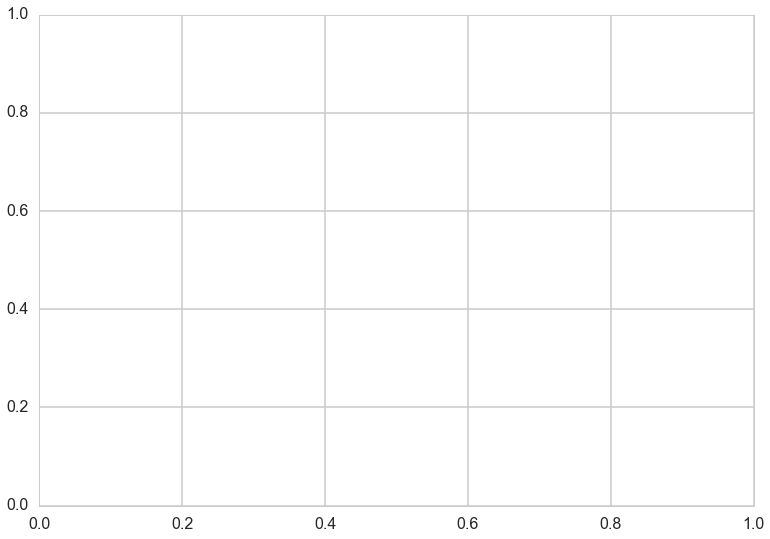

In [181]:
plt.plot(resultdf["cg27654142"], resultdf["age"])